<a href="https://colab.research.google.com/github/Atit-Bashyal/Merkel_1/blob/main/DNN_wind.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import pandas as pd
import math
import csv
from datetime import datetime
from datetime import timedelta
import time
import datetime 
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Conv1D, MaxPool2D, Flatten, Dropout
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, SGD, Nadam
from time import time
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller,acf, pacf

from matplotlib.pylab import rcParams
from matplotlib.pyplot import figure

import xlrd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
from itertools import product
import statsmodels.api as sm
from math import sqrt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import datetime
from keras.callbacks import EarlyStopping
import seaborn as sns
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler




%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"} # Make sure the axis background of plots is white, this is usefull for the black theme in JupyterLab
sns.set()

In [ ]:
merkel_1 = pd.read_csv('/content/drive/MyDrive/Wind_turbines/Meckel_1.csv',parse_dates=[0],index_col=0)
merkel_4 = pd.read_csv('/content/drive/MyDrive/Wind_turbines/Meckel_4.csv',parse_dates=[0],index_col=0)
rens_3 = pd.read_csv('/content/drive/MyDrive/Wind_turbines/Reinsfeld_3.csv',parse_dates=[0],index_col=0)

In [ ]:
merkel_1 = merkel_1[['power','wind_speed','wind_direction']]
merkel_1 = merkel_1.reset_index()
merkel_1['t'] = (merkel_1['datetime'] - merkel_1['datetime'].min()) / (merkel_1['datetime'].max() - merkel_1['datetime'].min())


In [ ]:
import time
from datetime import datetime
import calendar
merkel_1['Month'] = [x.month for x in merkel_1['datetime']]

In [ ]:
def w_output(S,d,of):
  offset_angle  = math.radians(d-of)
  val = S*(np.cos(offset_angle))** 2
  return val

def w_sin(d):

  val = np.sin(d)
  return val

def w_cos(d):
  val = np.cos(d)
  return val

In [ ]:
merkel_1['wind_direction_sin'] = merkel_1.apply(lambda row: w_sin(row['wind_direction']), axis=1)
#merkel_1['time_sin_month'] = merkel_1.apply(lambda row: w_sin((360/12)*row['t']), axis=1)
merkel_1['wind_direction_cos'] = merkel_1.apply(lambda row: np.cos(row['wind_direction']), axis=1)
#merkel_1['time_cos_month'] = merkel_1.apply(lambda row: w_cos((360/12)*row['t']), axis=1)
merkel_1['wind_output_50'] = merkel_1.apply(lambda row: w_output(row['wind_speed'], row['wind_direction'], 50), axis=1)
merkel_1['wind_output_200'] = merkel_1.apply(lambda row: w_output(row['wind_speed'], row['wind_direction'], 200), axis=1)
data = merkel_1.set_index('datetime')

In [ ]:
X = data.drop(['power'], axis=1)
#print('X columns: %s' % list(X.columns))

y = data['power']

#X = np.array(X).reshape(-1,len(X.columns)) # Reshape to required dimensions for sklearn
#y = np.array(y).reshape(-1,1)

train_size = 0.5

# Split train & test

split_index_test = int(data.shape[0]*train_size) # the index at which to split df into train and test

X_train = X[:split_index_test]
X_test = X[split_index_test:]

y_train = y[:split_index_test]
y_test = y[split_index_test:]

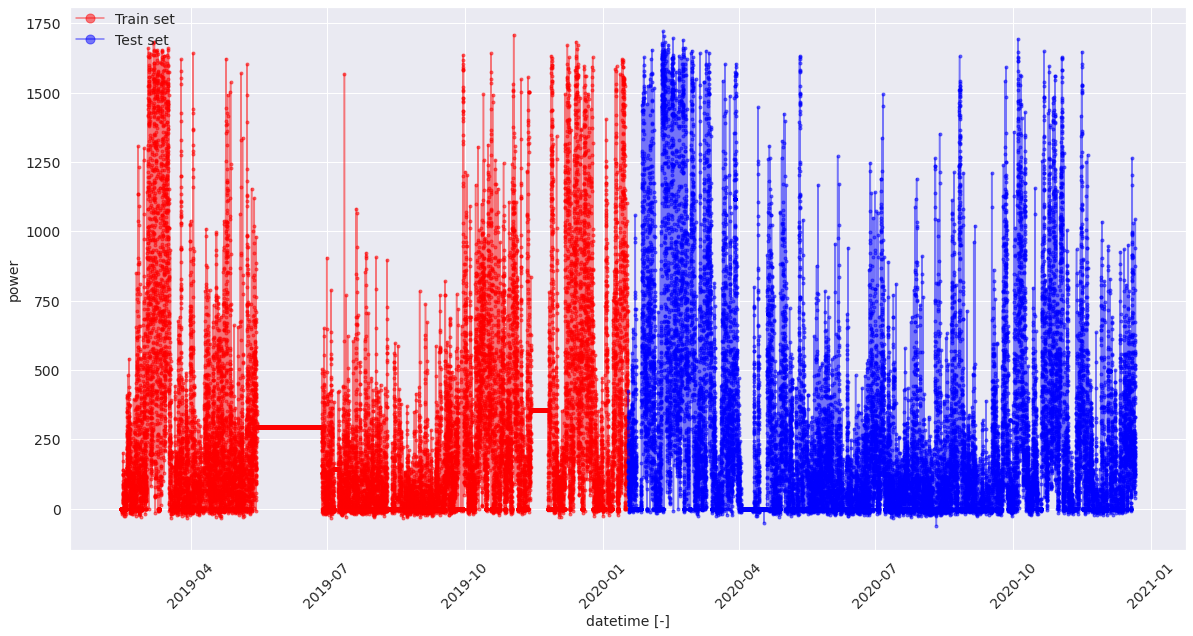

In [ ]:

plt.figure(figsize=(20,10))

plt.plot(X_train.index, y_train, '.-', color='red', label='Train set', alpha=0.5)
plt.plot(X_test.index, y_test, '.-', color='blue', label='Test set', alpha=0.5)

plt.ylabel(r'power', fontsize=14)
plt.xlabel('datetime [-]', fontsize=14) #TODO: set x values as actual dates

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

print((X_train.shape, y_train.shape))
print((X_test.shape, y_test.shape))

((32620, 8), (32620,))
((32620, 8), (32620,))


In [ ]:
def create_model():
    model = Sequential()
    model.add(Dense(64, input_shape=(X_train.shape[1],), kernel_initializer='TruncatedNormal', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.083))
    
    # 1
    for _ in range(0):
        model.add(Dense(32, kernel_initializer='TruncatedNormal', use_bias=False))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.156))   
    
    # 2
    for _ in range(0):
        model.add(Dense(32, kernel_initializer='TruncatedNormal', use_bias=False))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.899))
    

        
    model.add(Dense(1))
    
    return model

In [ ]:
#model = multi_gpu_model(model, gpus=num_gpu) # use this to use multiple GPUs

model = create_model()

lr = 1e-2
epochs = 10 # Two times
bs = 5
nadam = Nadam(lr=lr)


# compiling the sequential model
model.compile(loss='mse', optimizer='nadam')

print('Batch size: ', bs)

Batch size:  5


In [ ]:
# training the model and saving metrics in history
model.fit(X_train, y_train, batch_size=bs, epochs=epochs, verbose=1)

Epoch 1/10
6524/6524 [==============================] - 7s 1ms/step - loss: 41268.7891
Epoch 2/10
6524/6524 [==============================] - 7s 1ms/step - loss: 40797.2578
Epoch 3/10
6524/6524 [==============================] - 7s 1ms/step - loss: 39155.4023
Epoch 4/10
6524/6524 [==============================] - 7s 1ms/step - loss: 38952.9727
Epoch 5/10
6524/6524 [==============================] - 7s 1ms/step - loss: 38530.5039
Epoch 6/10
6524/6524 [==============================] - 7s 1ms/step - loss: 38702.5586
Epoch 7/10
6524/6524 [==============================] - 7s 1ms/step - loss: 38162.6641
Epoch 8/10
6524/6524 [==============================] - 7s 1ms/step - loss: 37655.9375
Epoch 9/10
6524/6524 [==============================] - 7s 1ms/step - loss: 37403.3516
Epoch 10/10
6524/6524 [==============================] - 7s 1ms/step - loss: 37185.5156


In [ ]:
y_pred = model.predict(X_test)


1020/1020 [==============================] - 1s 842us/step - loss: 18480.9727
FINISHED


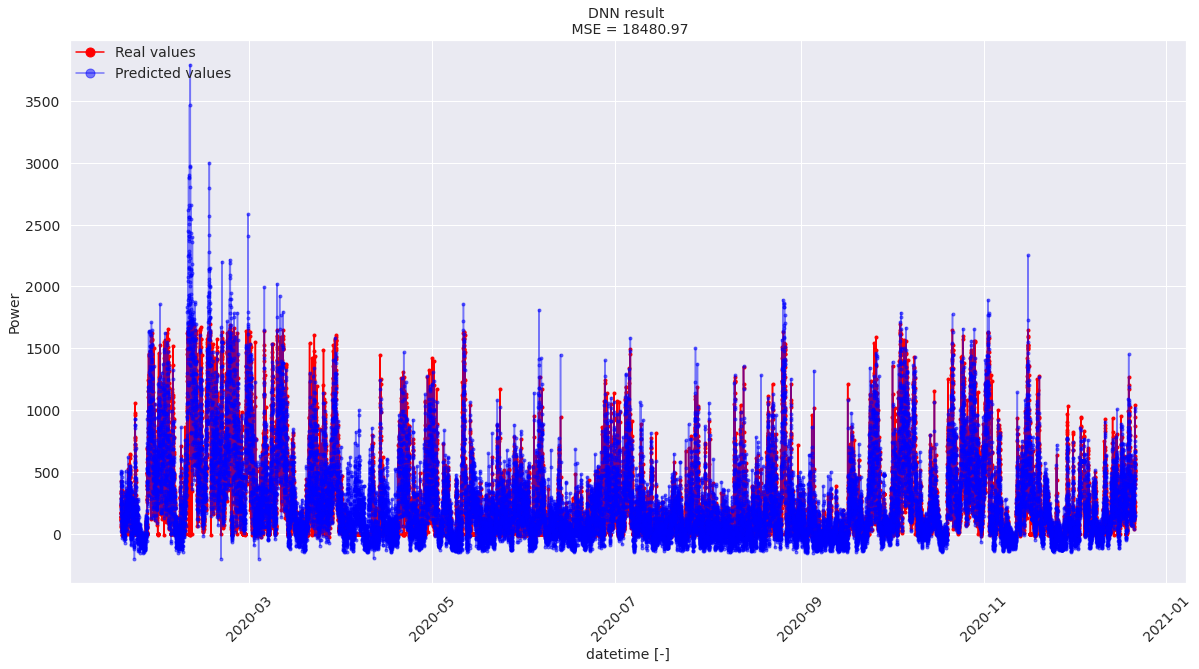

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(x.index, y_true, '.-', color='red', label='Real values', alpha=1)
plt.plot(x.index, y_pred, '.-', color='blue', label='Predicted values', alpha=0.5)

plt.ylabel(r'Power', fontsize=14)
plt.xlabel('datetime [-]', fontsize=14) #TODO: set x values as actual dates

plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)

plt.legend(loc='upper left', borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

mse_result = model.evaluate(X_test, y_test)

plt.title('DNN result \n MSE = %.2f' % (mse_result), fontsize = 14)

#plt.savefig('figures/Feedforward result hourly without dummy variables.png', dpi=1200)
print('FINISHED')